In [49]:
import json
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime
#from util import find_analogies as _find_analogies

import os
import sys
sys.path.append(os.path.abspath('..'))
from util import get_wikipedia_data
from brown import get_sentences_with_word2idx_limit_vocab, get_sentences_with_word2idx


In [50]:
def _find_analogies(w1, w2, w3, We, word2idx):
    king = We[word2idx[w1]]
    man = We[word2idx[w2]]
    woman = We[word2idx[w3]]
    v0 = king - man + woman

    def dist1(a, b):
        return np.linalg.norm(a - b)
    def dist2(a, b):
        return 1 - a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

    for dist, name in [(dist1, 'Euclidean'), (dist2, 'cosine')]:
        min_dist = float('inf')
        best_word = ''
        for word, idx in word2idx.items():
            if word not in (w1, w2, w3):
                v1 = We[idx]
                d = dist(v0, v1)
                if d < min_dist:
                    min_dist = d
                    best_word = word
        print ("closest match by", name, "distance:", best_word)
        print (w1, "-", w2, "=", best_word, "-", w3)

In [51]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [52]:
def init_weights(shape):
    return np.random.randn(*shape).astype(np.float32) / np.sqrt(sum(shape))


In [53]:
class Model(object):
    def __init__(self, D, V, context_sz):
        self.D = D # embedding dimension
        self.V = V # vocab size
        # NOTE: we will look context_sz to the right AND context_sz to the left
        #       so the total number of targets is 2*context_sz
        self.context_sz = context_sz

    def _get_pnw(self, X):
        # calculate Pn(w) - probability distribution for negative sampling
        # basically just the word probability ^ 3/4
        word_freq = {}
        word_count = sum(len(x) for x in X)
        for x in X:
            for xj in x:
                if xj not in word_freq:
                    word_freq[xj] = 0
                word_freq[xj] += 1
        self.Pnw = np.zeros(self.V)
        for j in range(2, self.V): # 0 and 1 are the start and end tokens, we won't use those here
            self.Pnw[j] = (word_freq[j] / float(word_count))**0.75
        # print "self.Pnw[2000]:", self.Pnw[2000]
        assert(np.all(self.Pnw[2:] > 0))
        return self.Pnw

    def _get_negative_samples(self, context, num_neg_samples):
        # temporarily save context values because we don't want to negative sample these
        saved = {}
        for context_idx in context:
            saved[context_idx] = self.Pnw[context_idx]
            # print "saving -- context id:", context_idx, "value:", self.Pnw[context_idx]
            self.Pnw[context_idx] = 0
        neg_samples = np.random.choice(
            range(self.V),
            size=num_neg_samples, # this is arbitrary - number of negative samples to take
            replace=False,
            p=self.Pnw / np.sum(self.Pnw),
        )
        # print "saved:", saved
        for j, pnwj in saved.items():
            self.Pnw[j] = pnwj
        assert(np.all(self.Pnw[2:] > 0))
        return neg_samples

    def fit(self, X, num_neg_samples=10, learning_rate=1e-4, mu=0.99, reg=0.1, epochs=10):
        N = len(X)
        V = self.V
        D = self.D
        self._get_pnw(X)

        # initialize weights and momentum changes
        self.W1 = init_weights((V, D))
        self.W2 = init_weights((D, V))
        dW1 = np.zeros(self.W1.shape)
        dW2 = np.zeros(self.W2.shape)

        costs = []
        cost_per_epoch = []
        sample_indices = range(N)
        for i in range(epochs):
            t0 = datetime.now()
            sample_indices = shuffle(sample_indices)
            cost_per_epoch_i = []
            for it in range(N):
                j = sample_indices[it]
                x = X[j] # one sentence

                # too short to do 1 iteration, skip
                if len(x) < 2 * self.context_sz + 1:
                    continue

                cj = []
                n = len(x)
                # for jj in xrange(n):
                ########## try one random window per sentence ###########
                jj = np.random.choice(n)
                
                # do the updates manually
                Z = self.W1[x[jj],:] # note: paper uses linear activation function

                start = max(0, jj - self.context_sz)
                end = min(n, jj + 1 + self.context_sz)
                context = np.concatenate([x[start:jj], x[(jj+1):end]])
                # NOTE: context can contain DUPLICATES!
                # e.g. "<UNKOWN> <UNKOWN> cats and dogs"
                context = np.array(list(set(context)), dtype=np.int32)
                # print "context:", context

                posA = Z.dot(self.W2[:,context])
                pos_pY = sigmoid(posA)

                neg_samples = self._get_negative_samples(context, num_neg_samples)

                # technically can remove this line now but leave for sanity checking
                # neg_samples = np.setdiff1d(neg_samples, Y[j])
                # print "number of negative samples:", len(neg_samples)
                negA = Z.dot(self.W2[:,neg_samples])
                neg_pY = sigmoid(-negA)
                c = -np.log(pos_pY).sum() - np.log(neg_pY).sum()
                cj.append(c / (num_neg_samples + len(context)))

                # positive samples
                pos_err = pos_pY - 1
                dW2[:, context] = mu*dW2[:, context] - learning_rate*(np.outer(Z, pos_err) + reg*self.W2[:, context])

                # negative samples
                neg_err = 1 - neg_pY
                dW2[:, neg_samples] = mu*dW2[:, neg_samples] - learning_rate*(np.outer(Z, neg_err) + reg*self.W2[:, neg_samples])

                self.W2[:, context] += dW2[:, context]
                # self.W2[:, context] /= np.linalg.norm(self.W2[:, context], axis=1, keepdims=True)
                self.W2[:, neg_samples] += dW2[:, neg_samples]
                # self.W2[:, neg_samples] /= np.linalg.norm(self.W2[:, neg_samples], axis=1, keepdims=True)

                # input weights
                gradW1 = pos_err.dot(self.W2[:, context].T) + neg_err.dot(self.W2[:, neg_samples].T)
                dW1[x[jj], :] = mu*dW1[x[jj], :] - learning_rate*(gradW1 + reg*self.W1[x[jj], :])

                self.W1[x[jj], :] += dW1[x[jj], :]
                # self.W1[x[jj], :] /= np.linalg.norm(self.W1[x[jj], :])

                cj = np.mean(cj)
                cost_per_epoch_i.append(cj)
                costs.append(cj)
                if it % 500 == 0:
                    sys.stdout.write("epoch: %d j: %d/ %d cost: %f\r" % (i, it, N, cj))
                    sys.stdout.flush()

            epoch_cost = np.mean(cost_per_epoch_i)
            cost_per_epoch.append(epoch_cost)
            print ("time to complete epoch %d:" % i, (datetime.now() - t0), "cost:", epoch_cost)
        plt.plot(costs)
        plt.title("Numpy costs")
        plt.show()

        plt.plot(cost_per_epoch)
        plt.title("Numpy cost at each epoch")
        plt.show()

    def fitt(self, X, num_neg_samples=10, learning_rate=1e-4, mu=0.99, reg=0.1, epochs=10):
        N = len(X)
        V = self.V
        D = self.D
        self._get_pnw(X)

        # initialize weights and momentum changes
        W1 = init_weights((V, D))
        W2 = init_weights((D, V))
        W1 = theano.shared(W1)
        W2 = theano.shared(W2)

        thInput = T.iscalar('input_word')
        thContext = T.ivector('context')
        thNegSamples = T.ivector('negative_samples')

        W1_subset = W1[thInput]
        W2_psubset = W2[:, thContext]
        W2_nsubset = W2[:, thNegSamples]
        p_activation = W1_subset.dot(W2_psubset)
        pos_pY = T.nnet.sigmoid(p_activation)
        n_activation = W1_subset.dot(W2_nsubset)
        neg_pY = T.nnet.sigmoid(-n_activation)
        cost = -T.log(pos_pY).sum() - T.log(neg_pY).sum()

        W1_grad = T.grad(cost, W1_subset)
        W2_pgrad = T.grad(cost, W2_psubset)
        W2_ngrad = T.grad(cost, W2_nsubset)

        W1_update = T.inc_subtensor(W1_subset, -learning_rate*W1_grad)
        W2_update = T.inc_subtensor(
            T.inc_subtensor(W2_psubset, -learning_rate*W2_pgrad)[:,thNegSamples], -learning_rate*W2_ngrad)
        # 2 updates for 1 variable
        # http://stackoverflow.com/questions/15917849/how-can-i-assign-update-subset-of-tensor-shared-variable-in-theano
        # http://deeplearning.net/software/theano/tutorial/faq_tutorial.html
        # https://groups.google.com/forum/#!topic/theano-users/hdwaFyrNvHQ

        updates = [(W1, W1_update), (W2, W2_update)]

        train_op = theano.function(
            inputs=[thInput, thContext, thNegSamples],
            outputs=cost,
            updates=updates,
            allow_input_downcast=True,
        )

        costs = []
        cost_per_epoch = []
        sample_indices = range(N)
        for i in range(epochs):
            t0 = datetime.now()
            sample_indices = shuffle(sample_indices)
            cost_per_epoch_i = []
            for it in range(N):
                j = sample_indices[it]
                x = X[j] # one sentence

                # too short to do 1 iteration, skip
                if len(x) < 2 * self.context_sz + 1:
                    continue

                cj = []
                n = len(x)
                # for jj in xrange(n):

                #     start = max(0, jj - self.context_sz)
                #     end = min(n, jj + 1 + self.context_sz)
                #     context = np.concatenate([x[start:jj], x[(jj+1):end]])
                #     # NOTE: context can contain DUPLICATES!
                #     # e.g. "<UNKOWN> <UNKOWN> cats and dogs"
                #     context = np.array(list(set(context)), dtype=np.int32)
                #     neg_samples = self._get_negative_samples(context, num_neg_samples)

                #     c = train_op(x[jj], context, neg_samples)
                #     cj.append(c / (num_neg_samples + len(context)))

                ########## try one random window per sentence ###########
                jj = np.random.choice(n)
                start = max(0, jj - self.context_sz)
                end = min(n, jj + 1 + self.context_sz)
                context = np.concatenate([x[start:jj], x[(jj+1):end]])
                # NOTE: context can contain DUPLICATES!
                # e.g. "<UNKOWN> <UNKOWN> cats and dogs"
                context = np.array(list(set(context)), dtype=np.int32)
                neg_samples = self._get_negative_samples(context, num_neg_samples)

                c = train_op(x[jj], context, neg_samples)
                cj.append(c / (num_neg_samples + len(context)))
                #########################################################


                cj = np.mean(cj)
                cost_per_epoch_i.append(cj)
                costs.append(cj)
                if it % 100 == 0:
                    sys.stdout.write("epoch: %d j: %d/ %d cost: %f\r" % (i, it, N, cj))
                    sys.stdout.flush()

            epoch_cost = np.mean(cost_per_epoch_i)
            cost_per_epoch.append(epoch_cost)
            print ("time to complete epoch %d:" % i, (datetime.now() - t0), "cost:", epoch_cost)

        self.W1 = W1.get_value()
        self.W2 = W2.get_value()

        plt.plot(costs)
        plt.title("Theano costs")
        plt.show()

        plt.plot(cost_per_epoch)
        plt.title("Theano cost at each epoch")
        plt.show()

    def save(self, fn):
        arrays = [self.W1, self.W2]
        np.savez(fn, *arrays)

In [54]:
def main(use_brown=True):
    if use_brown:
        # sentences, word2idx = get_sentences_with_word2idx_limit_vocab()
        sentences, word2idx = get_sentences_with_word2idx()
    else:
        sentences, word2idx = get_wikipedia_data(n_files=1, n_vocab=2000)
    with open('w2v_word2idx.json', 'w') as f:
        json.dump(word2idx, f)

    V = len(word2idx)
    model = Model(50, V, 5)
    model.fit(sentences, learning_rate=1e-3, mu=0, epochs=2, num_neg_samples=5)
    model.save('w2v_model.npz')




Vocab size: 49817
time to complete epoch 0: 0:06:54.660803 cost: 0.69314422522
time to complete epoch 1: 0:05:55.648002 cost: 0.693130671292


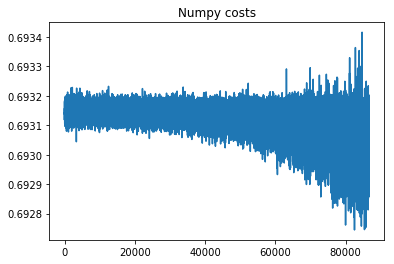

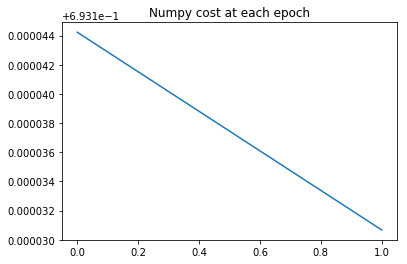

** concat: True
We.shape: (49817, 100)
closest match by Euclidean distance: urich
king - man = urich - woman
closest match by cosine distance: urich
king - man = urich - woman
We.shape: (49817, 100)
closest match by Euclidean distance: $133
france - paris = $133 - london
closest match by cosine distance: $133
france - paris = $133 - london
We.shape: (49817, 100)
closest match by Euclidean distance: quick-wate
france - paris = quick-wate - rome
closest match by cosine distance: younger
france - paris = younger - rome
We.shape: (49817, 100)
closest match by Euclidean distance: shook
paris - france = shook - italy
closest match by cosine distance: shook
paris - france = shook - italy
** concat: False
closest match by Euclidean distance: saledo
king - man = saledo - woman
closest match by cosine distance: saledo
king - man = saledo - woman
closest match by Euclidean distance: hans
france - paris = hans - london
closest match by cosine distance: hans
france - paris = hans - london
closest m

In [55]:
def find_analogies(w1, w2, w3, concat=True, we_file='w2v_model.npz', w2i_file='w2v_word2idx.json'):
    npz = np.load(we_file)
    W1 = npz['arr_0']
    W2 = npz['arr_1']

    with open(w2i_file) as f:
        word2idx = json.load(f)

    V = len(word2idx)

    if concat:
        We = np.hstack([W1, W2.T])
        print ("We.shape:", We.shape)
        assert(V == We.shape[0])
    else:
        We = (W1 + W2.T) / 2

    _find_analogies(w1, w2, w3, We, word2idx)

if __name__ == '__main__':
    main(use_brown=True)
    for concat in (True, False):
        print ("** concat:", concat)
        find_analogies('king', 'man', 'woman', concat=concat)
        find_analogies('france', 'paris', 'london', concat=concat)
        find_analogies('france', 'paris', 'rome', concat=concat)
        find_analogies('paris', 'france', 'italy', concat=concat)